# Starter Notebook

The goal of this notebook is to provide a brief introduction to the challenge and the data associated with it. It won't go into detail on a solution approach since this is a challenge which may be approached in a number of ways.

In [1]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments

# The Challenge

The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. Let's load the data and take a look.

In [15]:
# Load the data
df = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(df.shape)
df = df.sort_values(by='datetime')
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


In [16]:
df.tail()

,uid,datetime,latitude,longitude
6313,6314,2019-06-29 18:52:44,-1.262271,36.726540
6314,6315,2019-06-30 09:57:44,-1.279468,36.790449
6315,6316,2019-06-30 12:02:14,-1.322109,36.825248
6316,6317,2019-06-30 16:59:14,-1.278589,36.816518
6317,6318,2019-06-30 20:06:14,-1.211500,36.907635


<AxesSubplot:title={'center':'Crash Locations'}, xlabel='longitude', ylabel='latitude'>

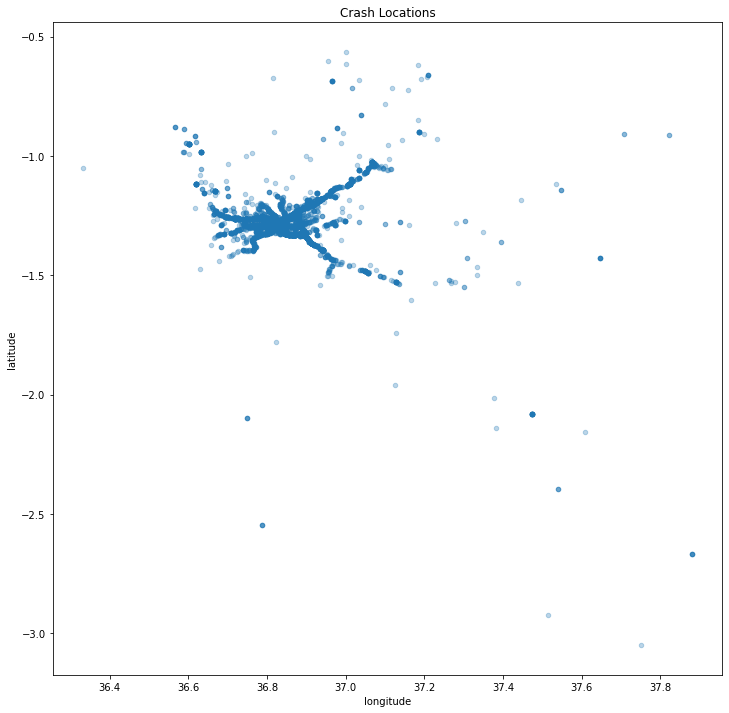

In [4]:
# Plot the crashes
df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

In [6]:
# View the submission format
ss = pd.read_csv('SampleSubmission.csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


# Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [7]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance


In [8]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3



score(sub, reference)

70886.38526378157

This scoring function can be used for local testing without needing to submit on Zindi. Lower is better. Experiment with specifying set locations for all 6 ambulances, and see how low you can get your score.

# Weather Data

Some weatehr variables form the GFS dataset are provided, covering the greater Nairobi area. Let's take a quick look at the dataset before moving on:

In [9]:
weather = pd.read_csv('Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather.head()

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


<AxesSubplot:xlabel='Date'>

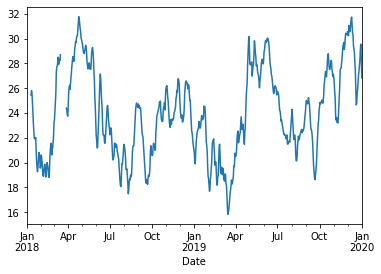

In [10]:
# Interestingly, Kenya has two rainy seasons per year!
weather.set_index('Date')['precipitable_water_entire_atmosphere'].rolling(10).mean().plot()

# Road Survey Data

The road survey data contains many different measurements for each surveyed road segment. Unfortunately we can't access the raw data, and must work 'in the dark' in terms of what the column headings mean. However, the naming convention does at least show which columns may be related.

To locate the road segments geographically, a geojson file is provided. Here is an example of merging the survey data with the segments and visualizing the result.

In [11]:
# Load the survey data
road_surveys = pd.read_csv('Segment_info.csv')
road_surveys.head()

,segment_id,side,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,...,80_97_61_65_11,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16
0,176_2,1,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,176_2,2,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,95_1,1,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95_1,2,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144_7,1,1,0,4,3,0.0,5,0,3,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [12]:
# Load the map
road_segment_locs = gpd.read_file('segments_geometry.geojson')
road_segment_locs.head()

,segment_id,road_name,geometry
0,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284..."
1,137_1,accra road-tertiary,"LINESTRING (36.82656 -1.28371, 36.82658 -1.283..."
2,137_2,accra road-tertiary,"LINESTRING (36.82711 -1.28289, 36.82713 -1.282..."
3,1_1,airport north road-primary,"LINESTRING (36.88646 -1.33284, 36.88649 -1.332..."
4,1_2,airport north road-primary,"LINESTRING (36.88726 -1.33226, 36.88729 -1.332..."


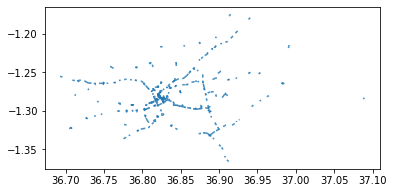

In [11]:
# Because this is a geodataframe, we can plot it
road_segment_locs.plot()

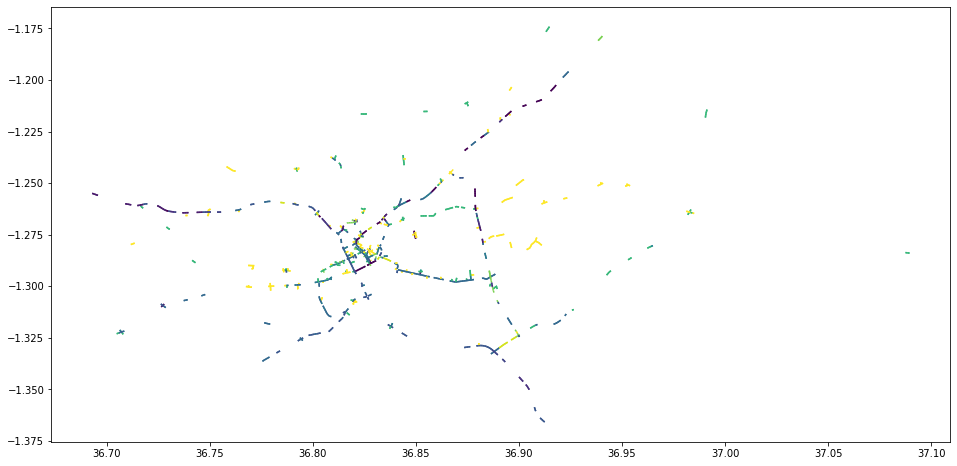

In [12]:
# Let's merge the two and color by one of the survey columns
segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
segments_merged.plot(column='55_90', figsize=(20, 8))

This data will come in useful if you're trying to predict the number of crashes along a particular road, or within a specified region. 

# Adding Uber Data

You can access speed data from https://movement.uber.com/explore/nairobi/speeds and clicking 'Download Data'. Here we'll load in the speeds from January 2019 and explore the data briefly.

In [13]:
speeds = pd.read_csv('../uber_data/movement-speeds-hourly-nairobi-2019-1.csv', parse_dates=['utc_timestamp'])
speeds.head()

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev
0,2019,1,21,18,2019-01-21 15:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.025,5.147
1,2019,1,22,15,2019-01-22 12:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.572,11.282
2,2019,1,8,17,2019-01-08 14:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,17.325,3.055
3,2019,1,12,21,2019-01-12 18:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.284,2.032
4,2019,1,14,9,2019-01-14 06:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.827,3.316


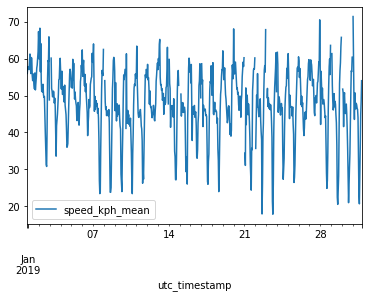

In [14]:
# Plot speeds over time for a specific OSM way
way = speeds.loc[speeds.osm_way_id == 133901081]
way = way.set_index('utc_timestamp')
way.resample('1h').mean().plot(y='speed_kph_mean')

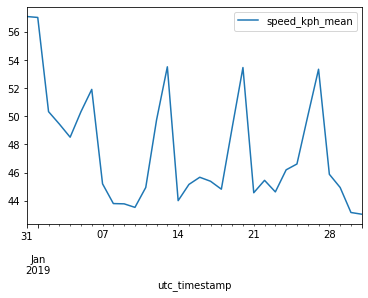

In [15]:
way.resample('1D').mean().plot(y='speed_kph_mean')

You can use any and all data available through Uber Movement, including linking the speeds data to OSM segments, downloading quarterly statistics, using the Movement Data Toolkit etc.

You can find much more info about working with the speeds data here: https://medium.com/uber-movement/working-with-uber-movement-speeds-data-cc01d35937b3 - including how to link the segment_id with OSM data

# What Next?

There are many ways you could approach this challenge. For example, you could:
- Create a model to predict the liklihood of an accident given a location, the features of the nearby road segments, the weather, the traffic speed and the time of day
- Use this model to predict the probability of crashes for different times+locations over the test period, and then sample from this probability distribution to generate plausible crash locations.
- Use an optimization technique to minimise the travel distance for the ambulances to your fake crash points. 

This might seem too complicated - perhaps simply picking 6 fixed locations based on the existing data will be enough? Or maybe it's worth setting separate locations during busy traffic times? 

Perhaps a Reinforcement Learning aproach will do well? 

Or maybe you can see a totally different way to solve this!

Share your ideas on the discussion boards, and let's see how innovative we can be :)